TO DO LIST:


*   ~~Criar uma imagem binaria como mapa de densidade a partir do mat(onde tiver um ponto no mat sera 1 na imagem e 0 onde não tem)~~
*   ~~Criar o cortador de imagens que corte imagens em dimensões que passei~~
*   ~~Testar o modelo com a imagem do mapa de densidade redimensionada para 200x200~~
*   ~~Testar o modelo com os recortes das imagem e do mapa de densidade~~
*   Lembrar de ajeitar a colsuta nos dados para as cores virem corretas
*   debugar o treinamento para ver o pq a saida sendo sempre 0

In [51]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [52]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
print ("OpenCV Version : %s " % cv2.__version__)
from scipy.io import loadmat

OpenCV Version : 4.10.0 


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.losses import RootMeanSquaredError

In [54]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [55]:
import scipy.io
import numpy as np
from scipy.ndimage import gaussian_filter
import os

# Tentativa 1

In [56]:
print(tf.__version__)

2.18.0


In [57]:
print(tf.config.list_physical_devices('GPU'))

[]


In [58]:

# Função para carregar e redimensionar os mapas de densidade (ground truths)
def load_density_maps(mat_folder):
    density_map_paths = []
    for filename in os.listdir(mat_folder):
        if filename.endswith(".mat"):
            mat_path = os.path.join(mat_folder, filename)
            density_map_paths.append(mat_path)
    return density_map_paths

def resize_density_map(density_maps, original_dimensions, img_size=(200, 200)):
    resized_maps = []
    for i in range(len(density_maps)):
        # density_maps[i] agora contém o caminho para o arquivo .mat
        mat_path = density_maps[i]
        mat_data = scipy.io.loadmat(mat_path)
        # Acessa os dados do mapa de densidade dentro do arquivo .mat
        ground_truth_points = mat_data['image_info'][0][0][0][0][0]  # Ajuste o índice se necessário
        # Cria o mapa de densidade a partir dos pontos
        density_map = np.zeros(original_dimensions[i], dtype=np.float32)
        for point in ground_truth_points:
            x, y = int(point[0]), int(point[1])
            if 0 <= x < original_dimensions[i][1] and 0 <= y < original_dimensions[i][0]:
                density_map[y, x] += 1  # Incrementa o contador no ponto correspondente

        # Redimensiona o mapa de densidade usando cv2.resize
        resized_map = cv2.resize(density_map, img_size)

        # Normaliza o mapa de densidade redimensionado
        #resized_map = resized_map / np.sum(resized_map) * len(ground_truth_points)

        resized_maps.append(resized_map)

    resized_maps = np.stack(resized_maps, axis=0)  # Empilha os mapas redimensionados
    return resized_maps



# Função para carregar e redimensionar as imagens
def load_images(image_folder, target_size=(200, 200)):
    images = []
    original_dimensions = []
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Redimensiona a imagem para 200x200
            img = cv2.resize(img, target_size)
            original_width = img.shape[1]
            original_height = img.shape[0]
            original_dimensions.append((original_width, original_height))
            images.append(np.array(img))

    # Convert the list of images to a NumPy array
    # and ensure it has the correct shape (num_samples, height, width, channels)
    images = np.array(images)
    #print(images.shape) # Check the shape after conversion

    return images,original_dimensions  # Normaliza entre 0 e 1

In [59]:
# Definir os caminhos relativos
mat_folder = r'Data\ShanghaiTech\part_A\train_data\ground-truth'
image_folder = r'Data\ShanghaiTech\part_A\train_data\images'


# Carrega e redimensiona as imagens e os ground truths
X_train, original_dimensions = load_images(image_folder)
Y_train = load_density_maps(mat_folder)
y_train_resized = resize_density_map(Y_train, original_dimensions)

In [60]:
X_train.shape

(300, 200, 200, 3)

* 300 é o numero de imagens
* 200 dimansão da imagem
* 200 dimensão da imagem
* numero de canais

In [61]:
y_train_resized.shape

(300, 200, 200)

In [62]:
len(X_train)

300

In [63]:
def custom_rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [64]:
model = Sequential()
model.add(Conv2D(24, (5, 5), activation='relu', padding='same', input_shape=(200,200,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(12, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))# Precisa para que a imagem de saida seja compativel com as dimensões de entrada
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (1, 1), activation='relu', padding='same'))
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_rmse, metrics=[RootMeanSquaredError()])

d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
# Especificar a GPU antes de treinar o modelo
with tf.device('/GPU:0'):
    model.fit(X_train, y_train_resized, epochs=30, batch_size=16)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.7526 - root_mean_squared_error: 1.5201
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0357 - root_mean_squared_error: 0.0361
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0356 - root_mean_squared_error: 0.0359
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0366 - root_mean_squared_error: 0.0372
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0365 - root_mean_squared_error: 0.0372
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0384 - root_mean_squared_error: 0.0388
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0373 - root_mean_squared_error: 0.0375
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0372 - root_mean_squared_error: 0.0378
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0374 - root_mean_squared_error: 0.0377
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0389 - root_mean_squared_err

In [66]:
# Carrega os dados de teste (mantendo a mesma lógica de redimensionamento)
image_test_folder = r"Data/ShanghaiTech/part_A/test_data/images/IMG_1.jpg"
img = cv2.imread(image_test_folder)
original_width = img.shape[1]
original_height = img.shape[0]
img = cv2.resize(img, (200, 200))
image_test=np.array(img)
image_test=image_test.reshape(1,200,200,3)
#X_test = load_images(image_test_folder)

In [67]:
image_test.shape

(1, 200, 200, 3)

In [68]:
# Faz uma previsão em uma imagem de teste
predicted_density = model.predict(image_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [69]:
mat_file = r"Data/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat"
# Substitua pelo caminho correto do seu arquivo .mat
mat_data = scipy.io.loadmat(mat_file)
ground_truth_points = mat_data['image_info'][0][0][0][0][0]
num_points_ground_truth = len(ground_truth_points)
print(f"Número de pontos no ground truth: {num_points_ground_truth}")

Número de pontos no ground truth: 172


In [70]:
intensity_sum_predicted = np.sum(predicted_density[0])
# predicted_density[0] corresponde à primeira imagem de teste
print(f"Soma das intensidades da imagem prevista: {intensity_sum_predicted}")

Soma das intensidades da imagem prevista: 0.0


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

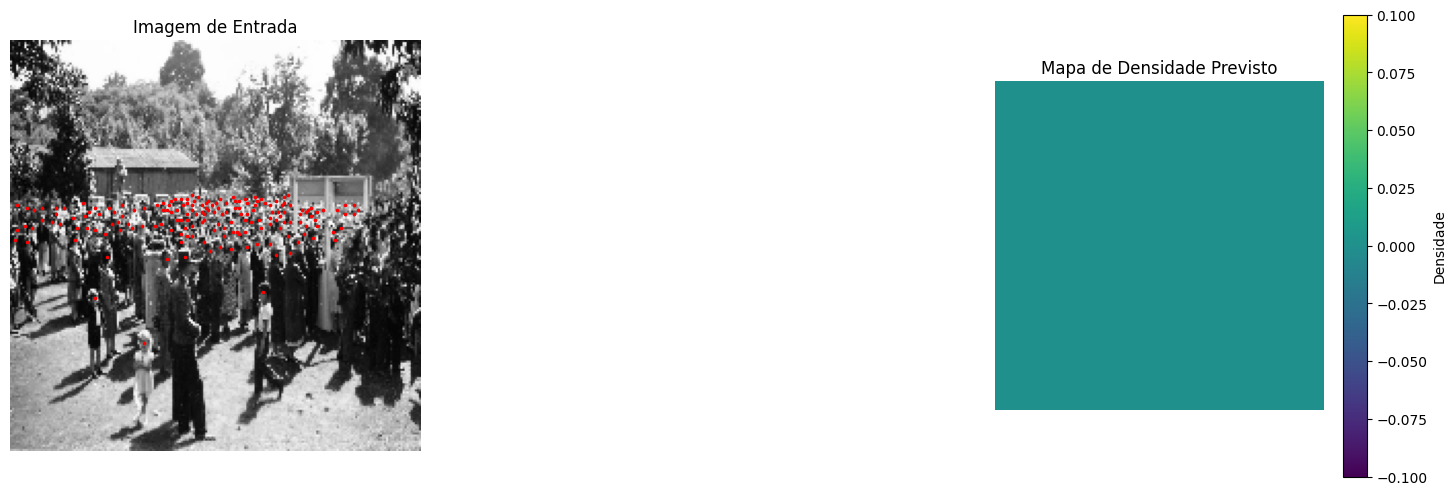

In [71]:
# Visualizar imagem de entrada, mapa real e mapa previsto
plt.figure(figsize=(18, 6))

# Imagem de entrada
plt.subplot(1, 3, 1)
plt.title("Imagem de Entrada")
plt.imshow(image_test[0])  # Mostra a imagem original
plt.axis('off')
# Obter as coordenadas dos pontos do ground truth
x_coords = [point[0] for point in ground_truth_points]
y_coords = [point[1] for point in ground_truth_points]

# Ajustando as coordenadas para corresponder ao tamanho da imagem redimensionada (200x200)
scale_factor_x = 200 / original_width # Using original width
scale_factor_y = 200 / original_height # Using original height

x_coords_scaled = [int(x * scale_factor_x) for x in x_coords]
y_coords_scaled = [int(y * scale_factor_y) for y in y_coords]

plt.scatter(x_coords_scaled, y_coords_scaled, s=10, color='red', marker='.')


# Mapa de densidade previsto
plt.subplot(1, 3, 3)
plt.title("Mapa de Densidade Previsto")
plt.imshow(predicted_density.squeeze())  # Remove dimensão extra
plt.colorbar(label="Densidade")
plt.axis('off')

# Tentativa 2

proposta interressante:
Ajuste a forma como você gera o mapa de densidade. Em vez de simplesmente definir os pixels como 1 onde há pessoas, considere usar uma função de kernel para criar um mapa de densidade mais suave. Isso pode ajudar a evitar que o mapa seja muito esparso.

In [72]:
def create_density_map_dataset(image_folder, mat_folder, target_size=(200, 200), kernel_size=15, sigma=4):
    """
    Cria um conjunto de dados de mapas de densidade a partir de imagens e arquivos .mat.

    Args:
        image_folder: Caminho para a pasta contendo as imagens.
        mat_folder: Caminho para a pasta contendo os arquivos .mat.
        target_size: Tamanho alvo para redimensionar as imagens e os mapas de densidade.

    Returns:
        Uma tupla contendo as imagens (X) e os mapas de densidade (Y).
    """

    X = []  # Lista para armazenar as imagens
    Y = []  # Lista para armazenar os mapas de densidade

    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
            # Carrega a imagem
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path)

            # Carrega o arquivo .mat correspondente
            mat_filename = "GT_" + filename.replace(os.path.splitext(filename)[1], '.mat')  # Substitui a extensão da imagem por .mat
            mat_path = os.path.join(mat_folder, mat_filename)
            mat_data = loadmat(mat_path)

            # Extrai as coordenadas dos pontos do arquivo .mat
            points = mat_data["image_info"][0][0][0][0][0]

            # Cria o mapa de densidade
            density_map = np.zeros(image.shape[:2], dtype=np.float32)  # Inicializa com zeros
            for point in points:
                x, y = int(point[0]), int(point[1])  # Converte as coordenadas para inteiros
                if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  # Verifica se as coordenadas estão dentro dos limites da imagem
                    density_map[y, x] = 1  # Define o valor como 1 nos pontos de localização das pessoas

            # Aplica a função de kernel (filtro gaussiano) para suavizar o mapa de densidade
            density_map = gaussian_filter(density_map, sigma=sigma, truncate=kernel_size/(2*sigma))
            # Redimensiona a imagem e o mapa de densidade
            resized_image = cv2.resize(image, target_size)
            resized_density_map = cv2.resize(density_map, target_size)

            # Adiciona a imagem e o mapa de densidade às listas
            X.append(resized_image)
            Y.append(resized_density_map)

    # Converte as listas em arrays NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y  # Retorna as imagens e os mapas de densidade

In [73]:
target_size=(800,800)
mat_folder = r"Data/ShanghaiTech/part_A/train_data/ground-truth"
image_folder = r"Data/ShanghaiTech/part_A/train_data/images"
X_train,Y_train=create_density_map_dataset(image_folder,mat_folder,target_size)

In [74]:
X_train.shape

(300, 800, 800, 3)

In [75]:
Y_train.shape

(300, 800, 800)

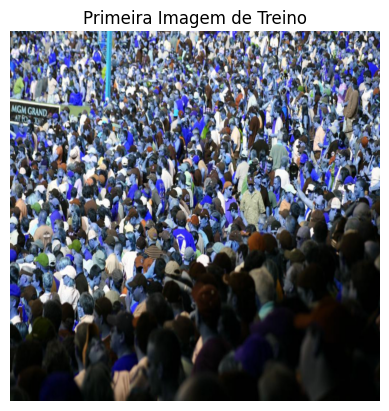

In [76]:
first_image = X_train[1]  # Seleciona a primeira imagem

plt.imshow(first_image)  # Exibe a imagem usando matplotlib
plt.title("Primeira Imagem de Treino")  # Define o título do gráfico
plt.axis('off')  # Remove os eixos do gráfico
plt.show()

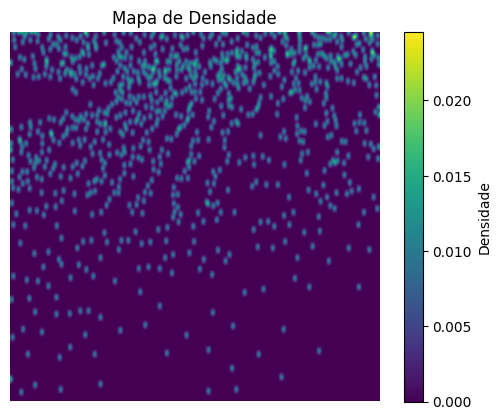

In [77]:
density_map_to_visualize = Y_train[1]

plt.imshow(density_map_to_visualize, cmap='viridis')  # Usa o mapa de cores 'viridis'
plt.colorbar(label="Densidade")  # Adiciona uma barra de cores
plt.title("Mapa de Densidade")  # Define o título do gráfico
plt.axis('off')  # Remove os eixos do gráfico
plt.show()

In [78]:
def custom_rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [79]:
model = Sequential()
model.add(Conv2D(24, (5, 5), activation='relu', padding='same', input_shape=(800,800,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(12, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))# Precisa para que a imagem de saida seja compativel com as dimensões de entrada
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (1, 1), activation='relu', padding='same'))
model.compile(optimizer=Adam(learning_rate=0.1), loss=custom_rmse, metrics=[RootMeanSquaredError()])

In [80]:
# Especificar a GPU antes de treinar o modelo
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train, epochs=1, batch_size=16)

19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 1.3564 - root_mean_squared_error: 2.8580


In [81]:
image_test_folder = r"Data/ShanghaiTech/part_A/test_data/images/IMG_10.jpg"
target_size=(800,800)
img = cv2.imread(image_test_folder)
original_width = img.shape[1]
original_height = img.shape[0]
img = cv2.resize(img, target_size)
image_test=np.array(img)
image_test=image_test.reshape(1,800,800,3)

In [82]:
predicted_density = model.predict(image_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


In [83]:
predicted_density

array([[[[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        ...,

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]]]], dtype=float32)

In [84]:
mat_file = r"Data/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat"
# Substitua pelo caminho correto do seu arquivo .mat
mat_data = scipy.io.loadmat(mat_file)
ground_truth_points = mat_data['image_info'][0][0][0][0][0]
num_points_ground_truth = len(ground_truth_points)
print(f"Número de pontos no ground truth: {num_points_ground_truth}")

Número de pontos no ground truth: 502


In [85]:
intensity_sum_predicted = np.sum(predicted_density)
# predicted_density[0] corresponde à primeira imagem de teste
print(f"Soma das intensidades da imagem prevista: {intensity_sum_predicted}")

Soma das intensidades da imagem prevista: 0.0


(np.float64(-0.5), np.float64(799.5), np.float64(799.5), np.float64(-0.5))

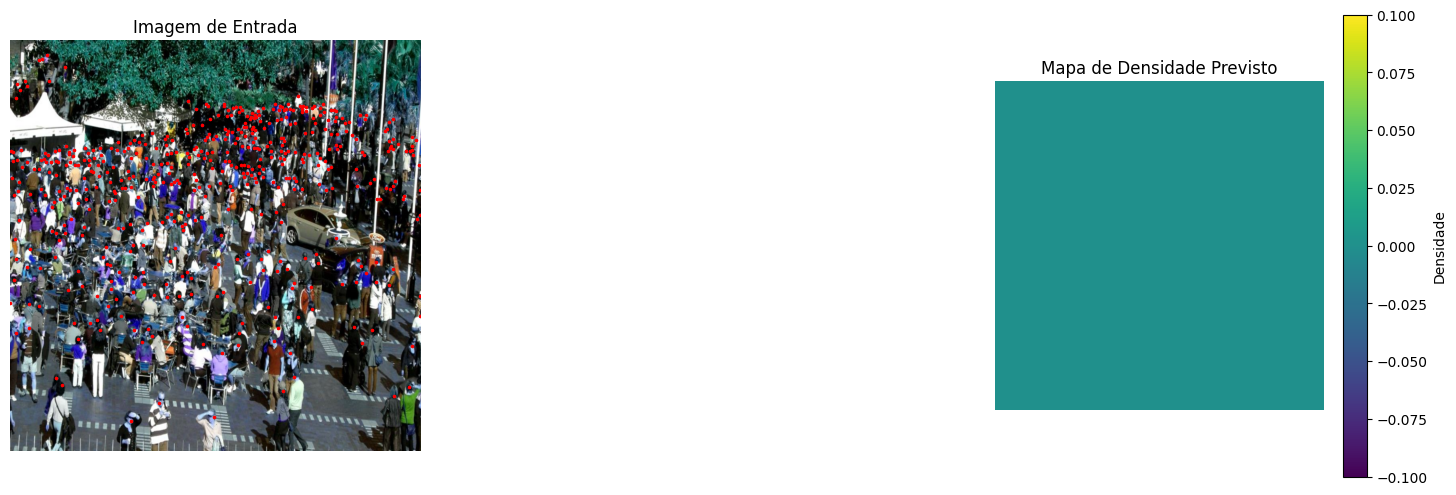

In [86]:
# Visualizar imagem de entrada, mapa real e mapa previsto
plt.figure(figsize=(18, 6))

# Imagem de entrada
plt.subplot(1, 3, 1)
plt.title("Imagem de Entrada")
plt.imshow(image_test[0])  # Mostra a imagem original
plt.axis('off')
# Obter as coordenadas dos pontos do ground truth
x_coords = [point[0] for point in ground_truth_points]
y_coords = [point[1] for point in ground_truth_points]

# Ajustando as coordenadas para corresponder ao tamanho da imagem redimensionada (200x200)
scale_factor_x = 800 / original_width # Using original width
scale_factor_y = 800 / original_height # Using original height

x_coords_scaled = [int(x * scale_factor_x) for x in x_coords]
y_coords_scaled = [int(y * scale_factor_y) for y in y_coords]

plt.scatter(x_coords_scaled, y_coords_scaled, s=10, color='red', marker='.')


# Mapa de densidade previsto
plt.subplot(1, 3, 3)
plt.title("Mapa de Densidade Previsto")
plt.imshow(predicted_density.squeeze())  # Remove dimensão extra
plt.colorbar(label="Densidade")
plt.axis('off')

# Preprocessamento

Os cortes geram num total 4500 imagens e mapas de densidade

Regressor 1: 658 Imagens e mapas de densidade para treino

Regressor 2: 855 Imagens e mapas de densidade para treino

Regressor 3: 2987 Imagens e mapas de densidade para treino

Hipoteses:

O regressor 3 está sobrecarregado com multiplas densidades

## Funções de preprocessamento

In [87]:
# Essa versão dos arquivos trabalho com mapa de densidade produzido a partir do arquivo mat
def image_crop(img,crop_size=(200,200), normalize=True):
    """
    Recorta uma imagem em patches de 200x200 pixels.

    Args:
        img: A imagem a ser recortada.

    Returns:
        Uma lista de patches de imagem de 200x200 pixels.
    """
    img_resized=cv2.resize(img, (1000,600))

    if len(img_resized.shape) == 3:
        height, width, _ = img_resized.shape
    else:  # Assume it's a grayscale image
        height, width = img_resized.shape  # Obtem altura e largura da imagem

    patches = []  # Lista para armazenar os patches

    # Itera sobre a imagem em passos de 200 pixels
    for y in range(0, height, crop_size[0]):
        for x in range(0, width, crop_size[1]):
            # Extrai o patch de 200x200
            patch = img_resized[y:y + crop_size[0], x:x + crop_size[1]]

            # Verifica se o patch tem o tamanho desejado (200x200)
            if patch.shape[0] == crop_size[0] and patch.shape[1] == crop_size[1]:
                if normalize:
                    # Normaliza os valores para o intervalo [0, 1]
                    patch = patch.astype('float32') / 255.0
                patches.append(np.array(patch))  # Adiciona o patch à lista

    return patches  # Retorna a lista de patches


def classifier_img(density_map):
  img_classe=[]
  for i in range(len(density_map)):
    soma_intensidades=np.sum(density_map[i])
    if soma_intensidades<=2:
      img_classe.append(0)
    elif soma_intensidades<=11:
      img_classe.append(1)
    else:
      img_classe.append(2)
  return img_classe


def preprocesso_dataset(image_folder, mat_folder, kernel_size=5, sigma=16):
    """
    Cria um conjunto de dados de mapas de densidade a partir de imagens e arquivos .mat.

    Args:
        image_folder: Caminho para a pasta contendo as imagens.
        mat_folder: Caminho para a pasta contendo os arquivos .mat.
        target_size: Tamanho alvo para redimensionar as imagens e os mapas de densidade.

    Returns:
        Uma tupla contendo as imagens (X) e os mapas de densidade (Y).
    """

    X = []  # Lista para armazenar as imagens
    Y = []  # Lista para armazenar os mapas de densidade
    class_reg=[]# Lista para armazenar as classes da imagem

    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
            # Carrega a imagem
            image_path = os.path.join(image_folder, filename)
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            # Carrega o arquivo .mat correspondente
            mat_filename = "GT_" + filename.replace(os.path.splitext(filename)[1], '.mat')  # Substitui a extensão da imagem por .mat
            mat_path = os.path.join(mat_folder, mat_filename)
            mat_data = loadmat(mat_path)

            # Extrai as coordenadas dos pontos do arquivo .mat
            points = mat_data["image_info"][0][0][0][0][0]

            # Cria o mapa de densidade
            density_map = np.zeros(image.shape[:2], dtype=np.float32)  # Inicializa com zeros
            for point in points:
                x, y = int(point[0]), int(point[1])  # Converte as coordenadas para inteiros
                if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  # Verifica se as coordenadas estão dentro dos limites da imagem
                    density_map[y, x] = 1  # Define o valor como 1 nos pontos de localização das pessoas

            # Aplica a função de kernel (filtro gaussiano) para suavizar o mapa de densidade
            density_map = gaussian_filter(density_map, sigma=sigma, truncate=kernel_size/(sigma))
            imgs_crop=image_crop(image)
            maps_crop=image_crop(density_map,normalize=False)

            #Pega a classe que pertence a imagem
            class_img=classifier_img(maps_crop)

            for i in range(len(imgs_crop)):
              X.append(imgs_crop[i])
              Y.append(maps_crop[i])
              class_reg.append(class_img[i])


    # Converte as listas em arrays NumPy
    X = np.array(X)
    Y = np.array(Y)
    class_reg=np.array(class_reg)

    return X, Y, class_reg  # Retorna as imagens e os mapas de densidade e as classes


## Teste com as funções que trabalham com mapas de densidade

In [88]:
mat_folder = r"Data/ShanghaiTech/part_A/train_data/ground-truth"
image_folder = r"Data/ShanghaiTech/part_A/train_data/images"
images,maps,img_classes=preprocesso_dataset(image_folder,mat_folder)

In [89]:
images.shape

(4500, 200, 200, 3)

In [90]:
maps.shape

(4500, 200, 200)

In [91]:
img_classes.shape

(4500,)

In [92]:
valores_unicos, contagem = np.unique(img_classes, return_counts=True)
contagens = dict(zip(valores_unicos, contagem))

In [93]:
for valor, contagem in contagens.items():
    print(f"Regressor {valor}: {contagem} Imagens de treino")

Regressor 0: 658 Imagens de treino
Regressor 1: 855 Imagens de treino
Regressor 2: 2987 Imagens de treino


Testes com os mapas

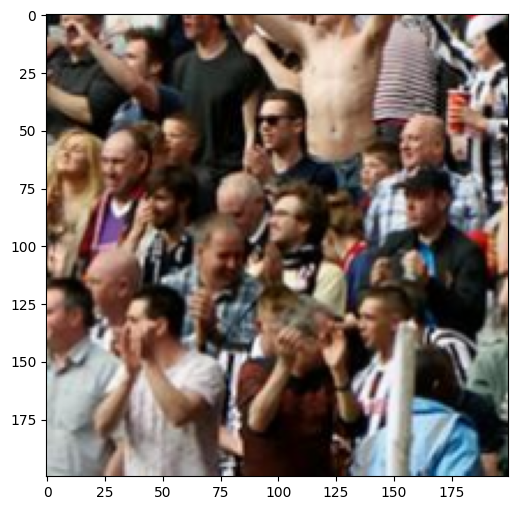

In [94]:
#Plot da Imagem:
plt.figure(figsize=(18, 6))
plt.imshow(images[4000])
plt.show()

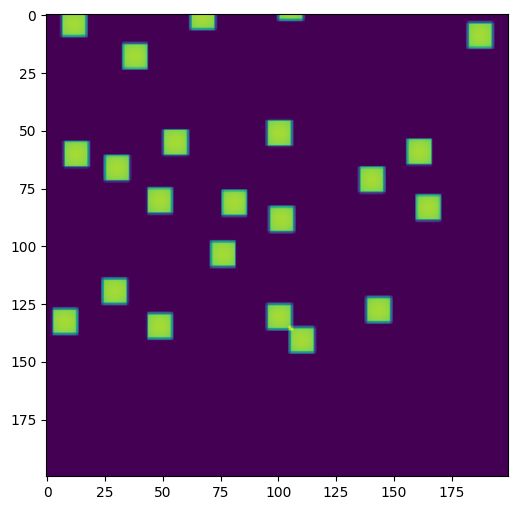

In [95]:
#Plot da Imagem:
plt.figure(figsize=(18, 6))
plt.imshow(maps[4000])
plt.show()

In [96]:
soma_intensidades = np.sum(maps[4000])
soma_intensidades

np.float32(20.37503)

# Dados de teste

In [97]:
mat_folder = r"Data/ShanghaiTech/part_A/test_data/ground-truth"
image_folder = r"Data/ShanghaiTech/part_A/test_data/images"
images_test,maps_test,img_classes_test=preprocesso_dataset(image_folder,mat_folder)

# Montar o Switch

Passo de aprendizado ideal=0,0001. 30 epocas, pode ocasionar overfit

In [102]:
img_classes.shape

(4500,)

In [101]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(200,200,3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
with tf.device('/GPU:0'):
    model.fit(images, img_classes, epochs=15, batch_size=32)

Epoch 1/15


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 3)

# Montar regressores

In [113]:
def custom_rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [114]:
model = Sequential()
model.add(Conv2D(24, (5, 5), activation='relu', padding='same', input_shape=(200,200,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(12, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))# Precisa para que a imagem de saida seja compativel com as dimensões de entrada
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (1, 1), activation='relu', padding='same'))
model.compile(optimizer=Adam(learning_rate=0.1), loss=custom_rmse, metrics=[RootMeanSquaredError()])

In [115]:
# Criando o modelo
model = Sequential()

# 1ª Camada Convolucional: Filtros 5x5 | 24
model.add(Conv2D(24, (5, 5), activation='relu', padding='same', input_shape=(200, 200, 3)))

# 2ª Camada: MaxPooling 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3ª Camada Convolucional: Filtros 3x3 | 48
model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))

# 4ª Camada: MaxPooling 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# 5ª Camada Convolucional: Filtros 3x3 | 24
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))

# 6ª Camada Convolucional: Filtros 3x3 | 12
model.add(Conv2D(12, (3, 3), activation='relu', padding='same'))

model.add(UpSampling2D((2, 2)))# Precisa para que a imagem de saida seja compativel com as dimensões de entrada
model.add(UpSampling2D((2, 2)))

# 7ª Camada Convolucional: Filtros 1x1 | 1
model.add(Conv2D(1, (1, 1), activation='relu', padding='same'))

# Resumo do modelo
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 200, 200, 24)   │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 100, 100, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 100, 100, 48)   │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 50, 50, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 50, 50, 24)     │        10,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 50, 50, 12)     │         2,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 100, 100, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 200, 200, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 200, 200, 1)    │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,249 (98.63 KB)

 Trainable params: 25,249 (98.63 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
# Criando o modelo
model = Sequential()

# 1ª Camada Convolucional: Filtros 5x5 | 24
model.add(Conv2D(24, (5, 5), activation='relu', padding='same', input_shape=(200, 200, 3)))

# 2ª Camada: MaxPooling 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3ª Camada Convolucional: Filtros 3x3 | 48
model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))

# 4ª Camada: MaxPooling 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# 5ª Camada Convolucional: Filtros 3x3 | 24
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))

# 6ª Camada Convolucional: Filtros 3x3 | 12
model.add(Conv2D(12, (3, 3), activation='relu', padding='same'))


model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Camada totalmente conectada intermediária
model.add(Dense(1, activation='linear'))

# Resumo do modelo

In [117]:
rmse_loss = tf.keras.metrics.RootMeanSquaredError()
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Otimizador Adam
    loss='mean_squared_error',                          # Erro quadrático médio para problemas de regressão
    metrics=['mae']                      # Erro absoluto médio como métrica adicional
)

In [118]:
images,maps,img_classes

(array([[[[0.99607843, 0.99215686, 1.        ],
          [0.9843137 , 0.98039216, 1.        ],
          [0.9882353 , 0.98039216, 1.        ],
          ...,
          [0.43137255, 0.37254903, 0.4117647 ],
          [0.5372549 , 0.46666667, 0.50980395],
          [0.74509805, 0.6784314 , 0.7176471 ]],
 
         [[0.9843137 , 0.98039216, 0.99607843],
          [0.99607843, 0.99215686, 1.        ],
          [0.9882353 , 0.9843137 , 0.99607843],
          ...,
          [0.48235294, 0.41960785, 0.45882353],
          [0.57254905, 0.49411765, 0.5372549 ],
          [0.70980394, 0.6392157 , 0.68235296]],
 
         [[0.99215686, 0.9882353 , 1.        ],
          [0.9882353 , 0.9843137 , 1.        ],
          [0.98039216, 0.9764706 , 0.99215686],
          ...,
          [0.45490196, 0.38431373, 0.42352942],
          [0.4745098 , 0.39607844, 0.4392157 ],
          [0.6901961 , 0.62352943, 0.6627451 ]],
 
         ...,
 
         [[0.6117647 , 0.6       , 0.6156863 ],
          [0.65098

In [119]:
indices_r3 = np.where(img_classes == 2)[0]

In [120]:
images_r3 = images[indices_r3]
maps_r3 = maps[indices_r3]

In [121]:
images_r3.shape

(2987, 200, 200, 3)

In [122]:
maps_r3.shape

(2987, 200, 200)

In [ ]:
with tf.device('/GPU:0'):
    model.fit(images_r3, maps_r3, epochs=15, batch_size=16)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mean_squared_error/sub/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Python312\Lib\asyncio\events.py", line 88, in _run

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Vinícius\AppData\Local\Temp\ipykernel_22884\1408956301.py", line 2, in <module>

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "d:\Vini\Aulas\RPAD\repository\Reconhecimento_de_Padroes\env\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 77, in train_step

Incompatible shapes: [16,200,200] vs. [16,1]
	 [[{{node gradient_tape/compile_loss/mean_squared_error/sub/BroadcastGradientArgs}}]] [Op:__inference_multi_step_on_iterator_19066]

In [ ]:
images_test,maps_test,img_classes_test

In [ ]:
indices_r3 = np.where(img_classes_test == 2)[0]
images_test_r3 = images_test[indices_r3]
maps_test_r3 = maps_test[indices_r3]

In [ ]:
predicted_density = model.predict(images_test_r3)

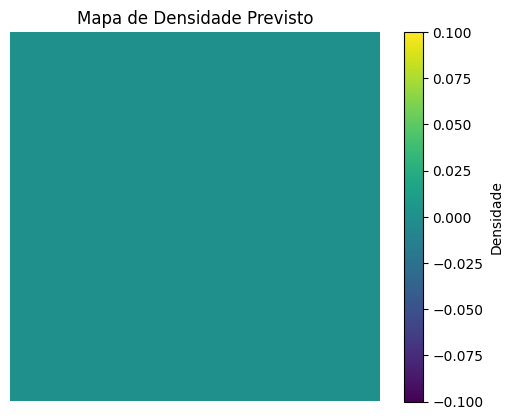

In [ ]:
plt.imshow(predicted_density[6], cmap='viridis')  # Usa o mapa de cores 'viridis'
plt.colorbar(label="Densidade")  # Adiciona uma barra de cores
plt.title("Mapa de Densidade Previsto")  # Define o título do gráfico
plt.axis('off')  # Remove os eixos do gráfico
plt.show()

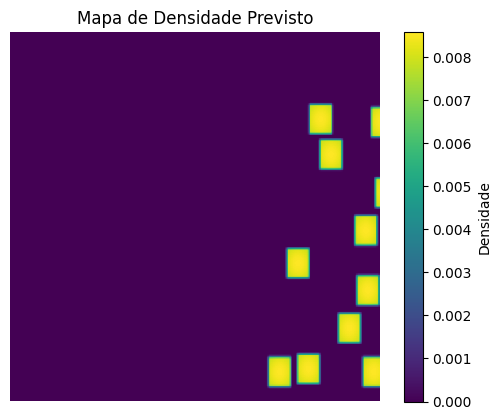

In [ ]:
plt.imshow(maps_test_r3[6], cmap='viridis')  # Usa o mapa de cores 'viridis'
plt.colorbar(label="Densidade")  # Adiciona uma barra de cores
plt.title("Mapa de Densidade Previsto")  # Define o título do gráfico
plt.axis('off')  # Remove os eixos do gráfico
plt.show()

In [ ]:
np.sum(predicted_density[6])

0.0

In [ ]:
np.sum(maps_test_r3[6])

15.245023